In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install -q tensorflow_datasets

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [4]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [5]:
num_classes = metadata.features['label'].num_classes
num_classes

5

In [6]:
get_label_name = metadata.features['label'].int2str

In [7]:
get_label_name(2)

'tulips'

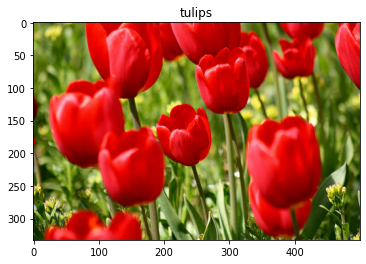

In [8]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [9]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1. / 255)
])

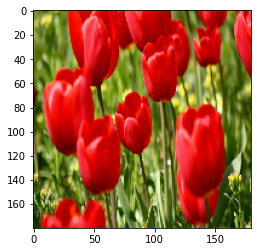

In [10]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [11]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
print(image.shape)
image = tf.expand_dims(image, 0) # Add the image to a batch
print(image.shape)

(333, 500, 3)
(1, 333, 500, 3)


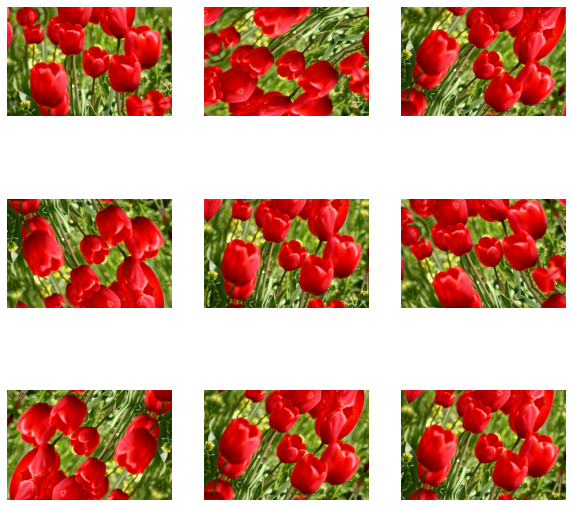

In [14]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

```python
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # Rest of your model
])
```

위와 같이 구성할 경우 장점

- data augmentation 과정이 GPU 가속의 이점을 누릴 수 있다.
- model.save로 이 모델을 저장하는 경우, 배포한 모델에 대해서도 이미지가 자동으로 표준화가 된다.

```python
aug_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y))
```

- data augmentation이 비동기적으로 발생합니다. ```Dataset.prefetch```를 사용하여 GPU 학습 중 데이터를 불러올 수 있습니다.
- 이 경우에는 모델 배포시에, 서버 측에서 다시 구현해야 합니다. 아니면 훈련 후 전처리 레이어를 연결할 수 있습니다.

In [15]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)
        
    ds = ds.batch(batch_size)
    
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
        
    return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [17]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
epochs=5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 2s 18ms/step - loss: 1.3445 - accuracy: 0.4387 - val_loss: 1.1440 - val_accuracy: 0.5422
Epoch 2/5
92/92 [==============================] - 1s 16ms/step - loss: 1.0569 - accuracy: 0.5743 - val_loss: 1.0354 - val_accuracy: 0.5967
Epoch 3/5
92/92 [==============================] - 1s 16ms/step - loss: 0.9849 - accuracy: 0.6066 - val_loss: 0.9760 - val_accuracy: 0.6049
Epoch 4/5
92/92 [==============================] - 1s 16ms/step - loss: 0.9288 - accuracy: 0.6339 - val_loss: 0.9699 - val_accuracy: 0.6240
Epoch 5/5
92/92 [==============================] - 1s 15ms/step - loss: 0.8988 - accuracy: 0.6441 - val_loss: 0.9770 - val_accuracy: 0.6322


In [20]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 0s 4ms/step - loss: 0.8844 - accuracy: 0.6567
Accuracy 0.6566757559776306


In [21]:
# 사용자가 직접 데이터 증가 레이어 추가하는 방법

def random_invert_img(x, p=0.5):
    if tf.random.uniform([]) < p:
        x = (255 - x)
    else:
        x
    return x

In [22]:
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

In [26]:
random_invert = random_invert()

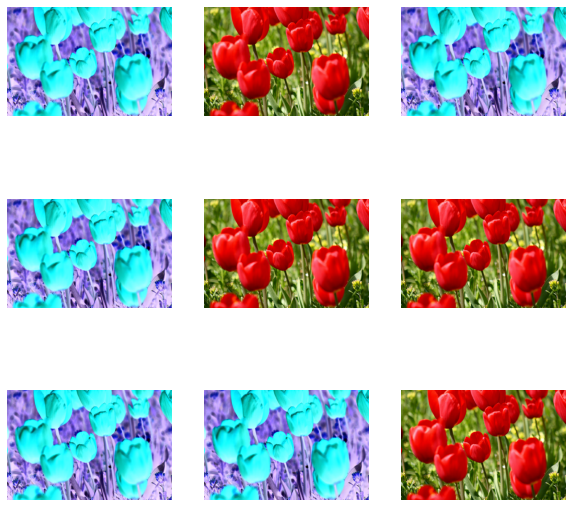

In [27]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [28]:
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

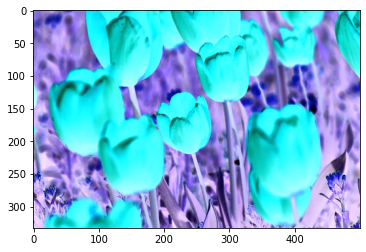

In [29]:
_ = plt.imshow(RandomInvert()(image)[0])

위의 layers.preprocessing 레이어는 편리합니다. 다만 보다 더 세밀한 제어를 위해 tf.data 및 tf.image를 사용하여 data augmentation, pipeline 등을 만들 수 있습니다.

In [30]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
        'tf_flowers',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        with_info=True,
        as_supervised=True,
)

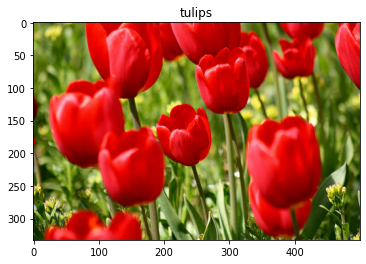

In [31]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [34]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(original)
    
    plt.subplot(1, 2, 2)
    plt.title('Augmented image')
    plt.imshow(augmented)

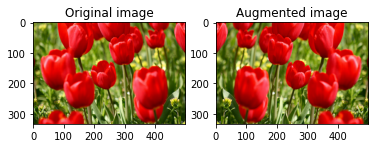

In [35]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

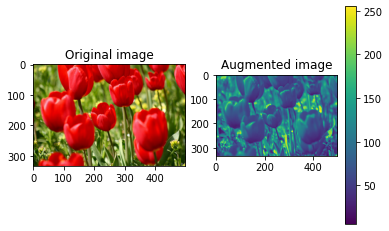

In [40]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled)) # tf.squeeze 없이도 잘 작동함. 
_ = plt.colorbar()

In [37]:
print(grayscaled.shape, tf.squeeze(grayscaled).shape)

(333, 500, 1) (333, 500)


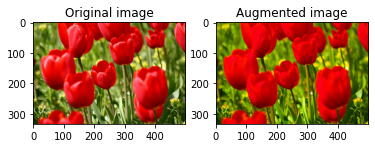

In [41]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

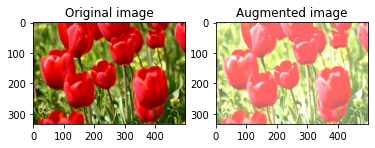

In [42]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

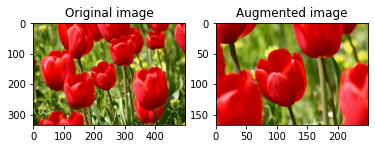

In [43]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

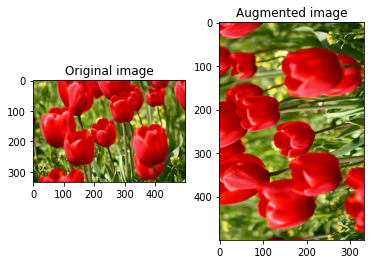

In [44]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

In [45]:
def risize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [51]:
tf.clip_by_value??

In [46]:
def augment(image, label):
    image, label = resize_and_rescale(image, label)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.clip_by_value(image, 0, 1) # 0 보다 작은 값은 0으로 1보다 큰 값은 1로..
    return image, label

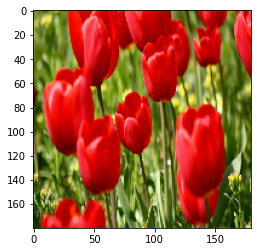

In [52]:
plt.imshow(tf.clip_by_value(resize_and_rescale(image), 0, 1).numpy())